# Import Libraries

In [1]:
import numpy as np
import pandas as pd

# from numba import njit
import math
import matplotlib.pyplot as plt
import os
from aeon.utils.numba.general import z_normalise_series_2d
from aeon.distances import get_distance_function
import time

In [2]:
# %load_ext autoreload
# %autoreload 2
from ksfdtw.distance_measures import (
    psdtw_prime_vanilla as psdtw_prime_vanilla,
    psdtw_prime_lb_shen as psdtw_prime_lb_shen,
    cut_based_distance as cut_based_distance,
)
from ksfdtw.utils import precision_at_k, nearest_neighbor_interpolation

# Import Dataset

In [3]:
dataset_name = "PowerCons"
P = 3
l = 1.5
data = np.load(
    f"../data_processed/{dataset_name}_P{P}_uniform.npz",
    allow_pickle=True,
)
trans_uniform_concatenated = data["X_train_trans_uniform_concatenated"]
# trans_uniform_concatenated = data["X_test_trans_uniform_concatenated"]

data = np.load(
    f"../data_processed/{dataset_name}_P{P}_l{l}_random.npz",
    allow_pickle=True,
)
trans_random_concatenated = data["X_train_trans_random_concatenated"]
# trans_random_concatenated = data["X_test_trans_random_concatenated"]

## Z-normalise the transformed series

In [4]:
trans_uniform_concatenated = z_normalise_series_2d(trans_uniform_concatenated)
trans_random_concatenated = z_normalise_series_2d(trans_random_concatenated)
instance_idx = 0

## Plot graph

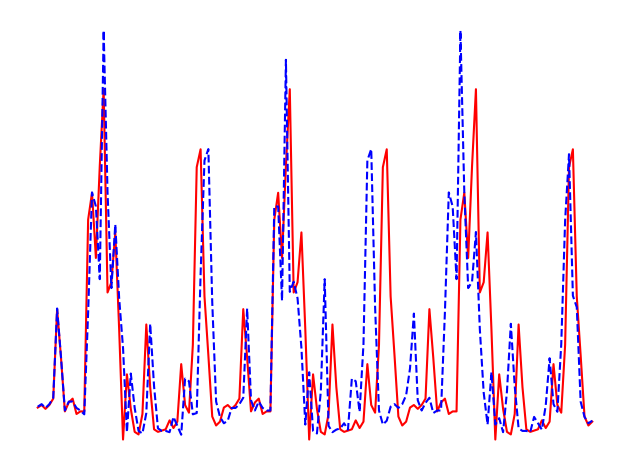

144

In [5]:
plt.plot(trans_uniform_concatenated[instance_idx], color="red")
plt.plot(trans_random_concatenated[instance_idx], color="blue", linestyle="--")
plt.axis("off")
plt.tight_layout()
# plt.savefig("../figures/concatenation_uniform_vs_random.pdf", format="pdf", bbox_inches="tight")
plt.show()
len(trans_uniform_concatenated[instance_idx])

## Assign query and target sets

In [6]:
# Query set
query_set = trans_random_concatenated

# Target set
target_set = trans_uniform_concatenated
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

# Searching with distance measures provided in aeon

## Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [13]:
# https://www.aeon-toolkit.org/en/latest/api_reference/distances.html
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
dist_funcs = {
    "squared": get_distance_function("squared"),
    "dtw": lambda Q, C: get_distance_function("dtw")(Q, C, window=0.1),
    "adtw": lambda Q, C: get_distance_function("adtw")(Q, C, window=0.1),
    "ddtw": lambda Q, C: get_distance_function("ddtw")(Q, C, window=0.1),
    # "erp": lambda Q, C: get_distance_function("erp")(Q, C, window=0.1),
    # "edr": lambda Q, C: get_distance_function("edr")(Q, C, window=0.1),
    # "lcss": lambda Q, C: get_distance_function("lcss")(Q, C, window=0.1),
    # "manhattan": get_distance_function("manhattan"),
    # "minkowski": get_distance_function("minkowski"),
    # "msm": lambda Q, C: get_distance_function("msm")(Q, C, window=0.1),
    # "sbd": get_distance_function("sbd"),
    "shape_dtw": lambda Q, C: get_distance_function("shape_dtw")(Q, C, window=0.1),
    # "twe": lambda Q, C: get_distance_function("twe")(Q, C, window=0.1),
    "wddtw": lambda Q, C: get_distance_function("wddtw")(Q, C, window=0.1),
    "wdtw": lambda Q, C: get_distance_function("wdtw")(Q, C, window=0.1),
}

In [14]:
for dist_name, dist_func in dist_funcs.items():
    # print(f"\n{'='*50}")
    # print(f"Evaluating: {dist_name}")
    # print(f"{'='*50}")
    start = time.time()
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array([dist_func(query_set[i], x) for x in target_set])

        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        precision_at_5 += precision_at_k(distances, i, 5)
        precision_at_7 += precision_at_k(distances, i, 7)
    print(
        f"{precision_at_1 / len(query_set):.2f}",
        f"{precision_at_3 / len(query_set):.2f}",
        f"{precision_at_5 / len(query_set):.2f}",
        f"{precision_at_7 / len(query_set):.2f}",
    )
    end = time.time()
    elapsed_time = end - start
    # print("Elapsed time for overall distance computation: " + str(elapsed_time))

0.26 0.43 0.51 0.55
0.77 0.98 1.00 1.00
0.80 1.00 1.00 1.00
0.77 0.98 0.99 1.00
0.77 0.99 0.99 1.00
0.77 0.99 1.00 1.00
0.77 0.99 1.00 1.00


# Searching with PSED, PSDTW

In [15]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen
# P = 3
if vanilla:
    dist_func_pp = lambda Q, C: psdtw_prime_vanilla(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )
else:
    dist_func_pp = lambda Q, C: psdtw_prime_lb_shen(
        Q, C, l=l, P=P, r=0.1, dist_method=dist_method
    )

dist_func_p = lambda Q, C: dist_func_pp(Q, C)
# new_len = 150
# dist_func_p = lambda Q, C: dist_func_pp(
#     nearest_neighbor_interpolation(Q, new_len),
#     nearest_neighbor_interpolation(C, new_len),
# )

## Warmup for numba

In [16]:
def dist_func(Q, C):
    dist, _, _ = dist_func_p(Q, C)
    return dist

In [17]:
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
start = time.time()
dist_func(
    trans_uniform_concatenated[instance_idx],
    trans_random_concatenated[instance_idx],
)
end = time.time()
elapsed_time = end - start
print("Elapsed time for a single distance computation: " + str(elapsed_time))

Elapsed time for a single distance computation: 0.032794952392578125


In [18]:
len(trans_uniform_concatenated[instance_idx])

144

## Precision@k

In [19]:
all_distances = []
all_count_dist_calls = []
all_cuts = []
start = time.time()
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    results = [dist_func_p(query_set[i], x) for x in target_set]
    dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
    distances = np.array(dist_arr)

    # store per-iteration results
    all_distances.append(distances)
    all_count_dist_calls.append(count_dist_calls_arr)
    all_cuts.append(cuts_arr)

    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f}",
    f"{precision_at_3 / len(query_set):.2f}",
    f"{precision_at_5 / len(query_set):.2f}",
    f"{precision_at_7 / len(query_set):.2f}",
)
end = time.time()
elapsed_time = end - start
print("Elapsed time: " + str(elapsed_time))

total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print("Total distance measure calls: " + str(total_count_dist_calls))

0.80 1.00 1.00 1.00
Elapsed time: 1496.843606710434
Total distance measure calls: 6698798003


In [20]:
os.makedirs("../outputs", exist_ok=True)
np.savez(
    f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}.npz",
    # f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}_newlen{new_len}.npz",
    all_distances=np.array(all_distances, dtype=object),
    all_count_dist_calls=np.array(all_count_dist_calls, dtype=object),
    all_cuts=np.array(all_cuts, dtype=object),
    precision_at_1=precision_at_1 / len(query_set),
    precision_at_3=precision_at_3 / len(query_set),
    precision_at_5=precision_at_5 / len(query_set),
    precision_at_7=precision_at_7 / len(query_set),
    elapsed_time=elapsed_time,
)

# Searching with Cut-based distance

## Import computed cuts

In [22]:
dist_method = 0  # 0 for PSED, 1 for PSDTW
vanilla = True  # True for vanilla, False for lb_shen

In [23]:
data = np.load(
    f"../outputs/{dataset_name}_P{P}_l{l}_dist_method{dist_method}_vanilla{vanilla}.npz",
    allow_pickle=True,
)

all_distances = np.ascontiguousarray(data["all_distances"], dtype=np.float64)
all_count_dist_calls = np.ascontiguousarray(
    data["all_count_dist_calls"], dtype=np.float64
)
all_cuts = np.ascontiguousarray(data["all_cuts"], dtype=np.float64)

In [24]:
all_cuts

array([[[[  0.,  48.,   0.,  46.],
         [ 48.,  92.,  46.,  97.],
         [ 92., 144.,  97., 144.]],

        [[  0.,  48.,   0.,  41.],
         [ 48.,  92.,  41.,  92.],
         [ 92., 144.,  92., 144.]],

        [[  0.,  46.,   0.,  43.],
         [ 46.,  87.,  43.,  91.],
         [ 87., 144.,  91., 144.]],

        ...,

        [[  0.,  48.,   0.,  44.],
         [ 48.,  95.,  44.,  97.],
         [ 95., 144.,  97., 144.]],

        [[  0.,  44.,   0.,  40.],
         [ 44.,  95.,  40.,  98.],
         [ 95., 144.,  98., 144.]],

        [[  0.,  42.,   0.,  40.],
         [ 42.,  95.,  40.,  98.],
         [ 95., 144.,  98., 144.]]],


       [[[  0.,  42.,   0.,  42.],
         [ 42.,  89.,  42.,  93.],
         [ 89., 144.,  93., 144.]],

        [[  0.,  56.,   0.,  50.],
         [ 56.,  98.,  50., 100.],
         [ 98., 144., 100., 144.]],

        [[  0.,  40.,   0.,  40.],
         [ 40.,  92.,  40.,  95.],
         [ 92., 144.,  95., 144.]],

        ...,

       

In [25]:
# def map_cuts_to_original_length(cuts, interpolated_len, original_len):
#     """
#     Map cut points from interpolated length back to original length.

#     Parameters
#     ----------
#     cuts : array-like
#         Cut points in the interpolated series (e.g., 0 to 100)
#     interpolated_len : int
#         Length of the interpolated series (e.g., 100)
#     original_len : int
#         Length of the original series (e.g., 150)

#     Returns
#     -------
#     mapped_cuts : np.ndarray
#         Cut points mapped to the original length
#     """
#     if len(cuts) == 0:
#         return np.array([])

#     cuts = np.array(cuts)
#     # Calculate the scaling factor
#     scale_factor = original_len / interpolated_len

#     # Map each cut point to the original length using nearest neighbor
#     mapped_cuts = np.round(cuts * scale_factor).astype(int)

#     # Ensure cuts are within valid range [0, original_len-1]
#     mapped_cuts = np.clip(mapped_cuts, 0, original_len)

#     return mapped_cuts

In [26]:
# def map_cuts_to_original_length2(cuts, interpolated_len, original_len):
#     """
#     Map cut points from interpolated length back to original length.

#     Parameters
#     ----------
#     cuts : array-like
#         Cut points in the interpolated series (e.g., 0 to 100)
#     interpolated_len : int
#         Length of the interpolated series (e.g., 100)
#     original_len : int
#         Length of the original series (e.g., 150)

#     Returns
#     -------
#     mapped_cuts : np.ndarray
#         Cut points mapped to the original length
#     """
#     if len(cuts) == 0:
#         return np.array([])

#     cuts = np.array(cuts, dtype=int)
#     mapped_cuts = np.empty(len(cuts), dtype=int)

#     # Use the inverse of nearest_neighbor_interpolation logic
#     # For each cut point j in the interpolated series (length L=interpolated_len),
#     # it corresponds to index: ceil((j+1) * k / L) - 1 in the original series (length k=original_len)
#     for i, j in enumerate(cuts):
#         mapped_cuts[i] = int(np.ceil((j + 1) * original_len / interpolated_len)) - 1

#     # Ensure cuts are within valid range [0, original_len]
#     mapped_cuts = np.clip(mapped_cuts, 0, original_len)

#     return mapped_cuts

In [27]:
# def map_cuts_to_original_length3(cuts, interpolated_len, original_len):
#     """
#     Map cut points from interpolated length back to original length.

#     Parameters
#     ----------
#     cuts : array-like
#         Cut points in the interpolated series (e.g., 0 to 100)
#     interpolated_len : int
#         Length of the interpolated series (e.g., 100)
#     original_len : int
#         Length of the original series (e.g., 150)

#     Returns
#     -------
#     mapped_cuts : np.ndarray
#         Cut points mapped to the original length
#     """
#     if len(cuts) == 0:
#         return np.array([])

#     cuts = np.array(cuts, dtype=np.float64)  # Use float64 for calculation

#     # Use the inverse of nearest_neighbor_interpolation logic
#     # For each cut point j in the interpolated series (length L=interpolated_len),
#     # it corresponds to index: ceil((j+1) * k / L) - 1 in the original series (length k=original_len)
#     mapped_cuts = np.ceil((cuts + 1) * original_len / interpolated_len) - 1
#     mapped_cuts = mapped_cuts.astype(int)

#     # Ensure cuts are within valid range [0, original_len]
#     mapped_cuts = np.clip(mapped_cuts, 0, original_len)

#     return mapped_cuts

In [28]:
# def map_cuts_to_original_length4(cuts, interpolated_len, original_len):
#     """
#     Map cut points from interpolated length back to original length.

#     Parameters
#     ----------
#     cuts : array-like
#         Cut points in the interpolated series (e.g., 0 to 100)
#     interpolated_len : int
#         Length of the interpolated series (e.g., 100)
#     original_len : int
#         Length of the original series (e.g., 150)

#     Returns
#     -------
#     mapped_cuts : np.ndarray
#         Cut points mapped to the original length
#     """
#     if len(cuts) == 0:
#         return np.array([])

#     cuts = np.array(cuts, dtype=np.float64)  # Use float64 for calculation

#     # Use the inverse of nearest_neighbor_interpolation logic
#     # For each cut point j in the interpolated series (length L=interpolated_len),
#     # it corresponds to index: ceil((j+1) * k / L) - 1 in the original series (length k=original_len)
#     # Special case: if j == 0, it should map to 0
#     mapped_cuts = np.where(
#         cuts == 0, 0, np.ceil((cuts + 1) * original_len / interpolated_len) - 1
#     )
#     mapped_cuts = mapped_cuts.astype(int)

#     # Ensure cuts are within valid range [0, original_len]
#     mapped_cuts = np.clip(mapped_cuts, 0, original_len)

#     return mapped_cuts

In [29]:
# # Example usage: Map all_cuts back to original length
# original_len = 286  # or use len(trans_uniform_concatenated[0]) before interpolation
# mapped_all_cuts = []
# for query_cuts in all_cuts:
#     mapped_query_cuts = []
#     for target_cut in query_cuts:
#         mapped_cut = map_cuts_to_original_length4(target_cut, new_len, original_len)
#         mapped_query_cuts.append(mapped_cut)
#     mapped_all_cuts.append(mapped_query_cuts)

# # mapped_all_cuts = np.array(mapped_all_cuts, dtype=object)
# mapped_all_cuts = np.ascontiguousarray(np.array(mapped_all_cuts, dtype=object), dtype=np.float64)

In [30]:
# all_cuts, type(all_cuts)

In [31]:
# type(mapped_all_cuts)

In [32]:
# type(all_cuts)

In [33]:
print(
    f"{data["precision_at_1"]:.2f}",
    f"{data["precision_at_3"]:.2f}",
    f"{data["precision_at_5"]:.2f}",
    f"{data["precision_at_7"]:.2f}",
)
print("Elapsed time:", data["elapsed_time"])

total_count_dist_calls = 0
for r in all_count_dist_calls:
    total_count_dist_calls += np.sum(r)
print("Total distance measure calls: " + str(total_count_dist_calls))

0.80 1.00 1.00 1.00
Elapsed time: 1496.843606710434
Total distance measure calls: 6698798003.0


## Compute Cut-based distances

In [37]:
# 0: aeon_squared_distance, 1: aeon_dtw_distance, 2: aeon_adtw_distance, 3: aeon_ddtw_distance, 4: aeon_erp_distance, 5: aeon_edr_distance
# 6: aeon_lcss_distance, 7: aeon_manhattan_distance, 8: aeon_minkowski_distance, 9: aeon_msm_distance, 10: aeon_sbd_distance
# 11: aeon_shape_dtw_distance, 12: aeon_twe_distance, 13: aeon_wddtw_distance, 14: aeon_wdtw_distance
# for i in range(0, 15):
for i in [0, 1, 2, 3, 11, 13, 14]:
    # print("dist_method: " + str(i))
    dist_method = i
    precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
    for i in range(0, len(query_set)):
        distances = np.array(
            [
                cut_based_distance(
                    query_set[i],
                    target_set[j],
                    l,
                    P,
                    0.1,
                    dist_method=dist_method,
                    # cuts=all_cuts[i][j],
                    cuts=all_cuts[i][j],
                )
                for j in range(0, len(target_set))
            ]
        )
        precision_at_1 += precision_at_k(distances, i, 1)
        precision_at_3 += precision_at_k(distances, i, 3)
        precision_at_5 += precision_at_k(distances, i, 5)
        precision_at_7 += precision_at_k(distances, i, 7)
    print(
        f"{precision_at_1 / len(query_set):.2f}",
        f"{precision_at_3 / len(query_set):.2f}",
        f"{precision_at_5 / len(query_set):.2f}",
        f"{precision_at_7 / len(query_set):.2f}",
    )

0.80 1.00 1.00 1.00
0.78 0.99 1.00 1.00
0.79 1.00 1.00 1.00
0.79 1.00 1.00 1.00
0.79 1.00 1.00 1.00
0.79 1.00 1.00 1.00
0.78 1.00 1.00 1.00


In [35]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-11-13 17:36:12.302647

